In [1]:
###归一化、无数据增强功能###
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Set random seed for PyTorch and NumPy
#seed = 14618
#torch.manual_seed(seed)
#np.random.seed(seed)

# Load your data from mydata_petals.csv
data = pd.read_csv('mydata_petals.csv')

# Extract the last column (EAB) as the target variable
EAB = data.iloc[:, -1].values

# Extract the first 10 columns as input features
input = data.iloc[:, :-1].values

# Create MinMaxScaler objects for input and EAB
scaler_in = MinMaxScaler(feature_range=(-0.5, 0.5))
scaler_out = MinMaxScaler(feature_range=(-0.99, 0.99))

# Fit and transform input data, and store the transformation matrix ps_in
p_scaled = scaler_in.fit_transform(input)
p = torch.FloatTensor(p_scaled.T)
ps_in = scaler_in.scale_

# Fit and transform EAB data, and store the transformation matrix ts_out
t_scaled = scaler_out.fit_transform(EAB.reshape(-1, 1))
t = torch.FloatTensor(t_scaled)
ts_out = scaler_out.scale_

print("Scaled Data Shapes:")
print(p_scaled.shape)
print(t_scaled.shape)

# Define the ratio for training and testing data
train_ratio = 0.8  # 80% training data, 
test_ratio = 0.2   # 20% testing data

# Number of samples
n_samples = len(EAB)

# Create a random permutation of indices for shuffling
indices = np.random.permutation(n_samples)

# Calculate the sizes of the training and test sets
n_train = int(train_ratio * n_samples)
n_test = n_samples - n_train

# Use the shuffled indices to split the data into training and test sets
train_indices = indices[:n_train]
test_indices = indices[n_train:]

# Split the data into training and test sets based on the shuffled indices
X_train, y_train = p_scaled[train_indices], t_scaled[train_indices]
X_test, y_test = p_scaled[test_indices], t_scaled[test_indices]

print("Training Data Shapes:")
print(X_train.shape, y_train.shape)
print("Test Data Shapes:")
print(X_test.shape, y_test.shape)

# 打印训练数据前五行
print("First 5 rows of Training Data:")
print(X_train[:5])
print("First 5 rows of Training Target (y_train):")
print(y_train[:5])

print("Test Data Shapes:")
print(X_test.shape, y_test.shape)

# 打印测试数据前五行
print("First 5 rows of Test Data:")
print(X_test[:5])
print("First 5 rows of Test Target (y_test):")
print(y_test[:5])

Scaled Data Shapes:
(2000, 10)
(2000, 1)
Training Data Shapes:
(1600, 10) (1600, 1)
Test Data Shapes:
(400, 10) (400, 1)
First 5 rows of Training Data:
[[-0.24663998  0.27882206  0.25610733 -0.3295     -0.11385597 -0.1694004
  -0.21332363  0.35519126  0.43224044  0.07558668]
 [ 0.45224478 -0.49711779  0.39947938  0.427       0.10437557 -0.43347913
  -0.15089188  0.03315118 -0.24735883  0.17454975]
 [-0.28996283  0.27518797  0.26331598 -0.128      -0.02689152  0.41379625
  -0.23316345  0.48233151  0.11639344  0.02337639]
 [-0.35430369 -0.14273183 -0.00740889  0.2955     -0.28067457 -0.44076909
  -0.15780852 -0.34189435 -0.49052823 -0.34136802]
 [ 0.11023735 -0.49511278 -0.469163    0.4065     -0.33992707 -0.45990523
  -0.3902439  -0.14462659 -0.48542805 -0.44142259]]
First 5 rows of Training Target (y_train):
[[ 0.31549451]
 [-0.40252747]
 [ 0.55483516]
 [-0.33725275]
 [-0.33725275]]
Test Data Shapes:
(400, 10) (400, 1)
First 5 rows of Test Data:
[[-0.44195024  0.18997494 -0.37865439  0

#GPU-version使用模拟退火算法完成了Dnn网络权重和偏差的初始化##
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Define the architecture of the DNN with hidden layers
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DNN, self).__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(1, len(dims)):
            self.layers.append(nn.Linear(dims[i - 1], dims[i]))
            if i < len(dims) - 1:
                self.layers.append(nn.Tanh())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Hyperparameters
input_dim = 10
output_dim = 1
hidden_dims = [12, 10, 6, 3] 
learning_rate = 0.01
max_epochs = 3000

# Initialize the DNN
dnn = DNN(input_dim, output_dim, hidden_dims).to('cuda')
criterion = nn.MSELoss()

# Convert data to PyTorch tensors
inputs = torch.FloatTensor(X_train).to('cuda') 
targets = torch.FloatTensor(y_train).to('cuda')

# Define the simulated annealing parameters
initial_params = [p.data.to('cuda').numpy() for p in dnn.parameters()]
max_iterations = 1000
initial_temperature = 100
cooling_rate = 0.99


def cost_function(params):
    # Initialize a new DNN with the same architecture
    new_dnn = DNN(input_dim, output_dim, hidden_dims)
    # Copy the current model parameters
    for new_param, current_param in zip(new_dnn.parameters(), params):
        new_param.data = torch.FloatTensor(current_param)
    
    # Convert data to PyTorch tensors
    new_inputs = torch.FloatTensor(X_train)
    new_targets = torch.FloatTensor(y_train)
    
    # Forward pass
    new_outputs = new_dnn(new_inputs)

    # Calculate the loss
    loss = criterion(new_outputs, new_targets)

    return loss.item()

current_params = initial_params
current_cost = cost_function(current_params)
best_params = current_params
best_cost = current_cost
temperature = initial_temperature

for i in range(max_iterations):
    # Generate a new solution by perturbing the current parameters
    new_params = [p + np.random.normal(0, 0.1, size=p.shape) for p in current_params]
    new_cost = cost_function(new_params)

    # Calculate the cost change
    cost_change = new_cost - current_cost

    # Accept the new solution with a certain probability
    if cost_change < 0 or np.random.rand() < np.exp(-cost_change / temperature):
        current_params = new_params
        current_cost = new_cost

    # Update the best solution if needed
    if current_cost < best_cost:
        best_params = current_params
        best_cost = current_cost

    # Decrease the temperature
    temperature *= cooling_rate

# Update the DNN with the best parameters
for param, best_param in zip(dnn.parameters(), best_params):
    param.data = torch.FloatTensor(best_param)

# Training with optimized weights
optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
losses = []

for epoch in range(max_epochs):
    optimizer.zero_grad()
    outputs = dnn(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Plot the loss curve
plt.figure()
plt.plot(range(1, max_epochs + 1), losses, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

Training duration: 0.88 seconds


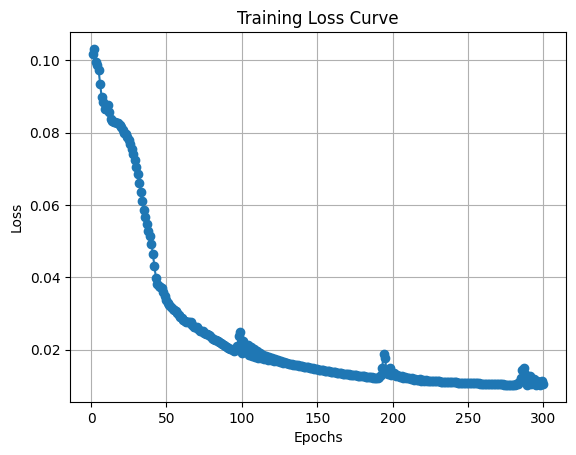

In [2]:
#CPU-version使用模拟退火算法完成了Dnn网络权重和偏差的初始化##
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import time

# Define the architecture of the DNN with hidden layers
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DNN, self).__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(1, len(dims)):
            self.layers.append(nn.Linear(dims[i - 1], dims[i]))
            if i < len(dims) - 1:
                self.layers.append(nn.Tanh())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Hyperparameters
input_dim = 10
output_dim = 1
hidden_dims = [14, 12, 8, 3] 

learning_rate = 0.02
max_epochs = 300

# Initialize the DNN
dnn = DNN(input_dim, output_dim, hidden_dims)
criterion = nn.MSELoss()

# Convert data to PyTorch tensors
inputs = torch.FloatTensor(X_train)
targets = torch.FloatTensor(y_train)

# Define the simulated annealing parameters
initial_params = [p.data.numpy() for p in dnn.parameters()]
max_iterations = 400
initial_temperature = 100
cooling_rate = 0.99
def cost_function(params):
    # Initialize a new DNN with the same architecture
    new_dnn = DNN(input_dim, output_dim, hidden_dims)
    # Copy the current model parameters
    for new_param, current_param in zip(new_dnn.parameters(), params):
        new_param.data = torch.FloatTensor(current_param)
    
    # Convert data to PyTorch tensors
    new_inputs = torch.FloatTensor(X_train)
    new_targets = torch.FloatTensor(y_train)
    
    # Forward pass
    new_outputs = new_dnn(new_inputs)

    # Calculate the loss
    loss = criterion(new_outputs, new_targets)

    return loss.item()

current_params = initial_params
current_cost = cost_function(current_params)
best_params = current_params
best_cost = current_cost
temperature = initial_temperature
# Record the start time
start_time = time.time()

for i in range(max_iterations):
    # Generate a new solution by perturbing the current parameters
    new_params = [p + np.random.normal(0, 0.1, size=p.shape) for p in current_params]
    new_cost = cost_function(new_params)

    # Calculate the cost change
    cost_change = new_cost - current_cost

    # Accept the new solution with a certain probability
    if cost_change < 0 or np.random.rand() < np.exp(-cost_change / temperature):
        current_params = new_params
        current_cost = new_cost

    # Update the best solution if needed
    if current_cost < best_cost:
        best_params = current_params
        best_cost = current_cost

    # Decrease the temperature
    temperature *= cooling_rate

# Update the DNN with the best parameters
for param, best_param in zip(dnn.parameters(), best_params):
    param.data = torch.FloatTensor(best_param)

# Training with optimized weights
optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
losses = []
for epoch in range(max_epochs):
    optimizer.zero_grad()
    outputs = dnn(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Record the end time
end_time = time.time()
# Calculate and print the training duration
training_duration = end_time - start_time
print(f"Training duration: {training_duration:.2f} seconds")

# Plot the loss curve

plt.figure()
plt.plot(range(1, max_epochs + 1), losses, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()


R-squared (r_train) on training set: 0.896
Mean Absolute Error (MAE) on training set: 0.081
Mean Squared Error (MSE) on training set: 0.010
Root Mean Squared Error (RMSE) on training set: 0.102
R-squared (r_test) on test set: 0.819
Mean Absolute Error (MAE) on test set: 0.104
Mean Squared Error (MSE) on test set: 0.017
Root Mean Squared Error (RMSE) on test set: 0.132


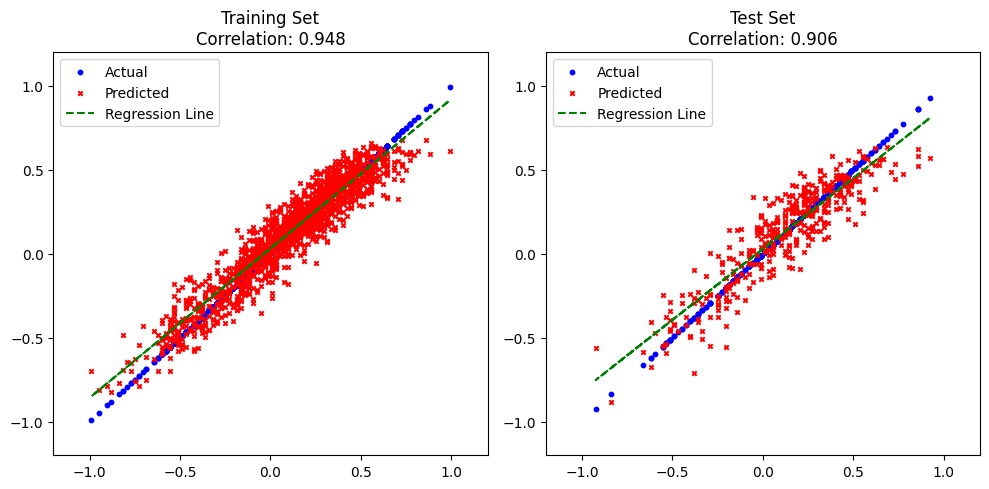

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
with torch.no_grad():
    predicted_train = dnn(torch.FloatTensor(X_train))
    train_true_values = y_train
    r_train = r2_score(train_true_values, predicted_train)
    mae_train = mean_absolute_error(train_true_values, predicted_train)   # MAE training set
    mse_train = mean_squared_error(train_true_values, predicted_train)    # MSE training set
    rmse_train = math.sqrt(mse_train)                               # RMSE training set

print(f"R-squared (r_train) on training set: {r_train:.3f}")
print(f"Mean Absolute Error (MAE) on training set: {mae_train:.3f}")
print(f"Mean Squared Error (MSE) on training set: {mse_train:.3f}")
print(f"Root Mean Squared Error (RMSE) on training set: {rmse_train:.3f}")

with torch.no_grad():              # Perform regression analysis on the test set (X_test, y_test)
    predicted_test = dnn(torch.FloatTensor(X_test))
    test_true_values = y_test
    r_test = r2_score(test_true_values, predicted_test)
    mae_test = mean_absolute_error(test_true_values, predicted_test)   #MAE test set
    mse_test = mean_squared_error(test_true_values, predicted_test)    # MSE test set
    rmse_test = math.sqrt(mse_test)                               #RMSE test set
    predicted_train = dnn(torch.FloatTensor(X_train))

print(f"R-squared (r_test) on test set: {r_test:.3f}")
print(f"Mean Absolute Error (MAE) on test set: {mae_test:.3f}")
print(f"Mean Squared Error (MSE) on test set: {mse_test:.3f}")
print(f"Root Mean Squared Error (RMSE) on test set: {rmse_test:.3f}")


import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

actual_train = y_train
actual_test = y_test  # Replace 'y_test' with your test labels

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot of actual values and regression line for training set
axes[0].scatter(actual_train, actual_train, color='blue', label='Actual', marker='o', s=10)
axes[0].scatter(actual_train, predicted_train, color='red', label='Predicted', marker='x', s=10)
axes[0].set_xlim(-1.2, 1.2)
axes[0].set_ylim(-1.2, 1.2)
correlation_train = np.corrcoef(actual_train, predicted_train, rowvar=False)[0, 1]
axes[0].set_title(f'Training Set\nCorrelation: {correlation_train:.3f}')
regression_train = LinearRegression()
regression_train.fit(actual_train.reshape(-1, 1), predicted_train)
regression_line_train = regression_train.predict(actual_train.reshape(-1, 1))
axes[0].plot(actual_train, regression_line_train, color='green', linestyle='--', label='Regression Line')
axes[0].legend()

# Scatter plot of actual values and regression line for test set
axes[1].scatter(actual_test, actual_test, color='blue', label='Actual', marker='o', s=10)
axes[1].scatter(actual_test, predicted_test, color='red', label='Predicted', marker='x', s=10)
axes[1].set_xlim(-1.2, 1.2)
axes[1].set_ylim(-1.2, 1.2)
correlation_test = np.corrcoef(actual_test, predicted_test, rowvar=False)[0, 1]
axes[1].set_title(f'Test Set\nCorrelation: {correlation_test:.3f}')
regression_test = LinearRegression()
regression_test.fit(actual_test.reshape(-1, 1), predicted_test)
regression_line_test = regression_test.predict(actual_test.reshape(-1, 1))
axes[1].plot(actual_test, regression_line_test, color='green', linestyle='--', label='Regression Line')
axes[1].legend()
plt.tight_layout()
plt.show()

# 使用GA算法完成每一训练轮次DNN权重和偏差的寻优
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Define the architecture of the DNN with hidden layers
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DNN, self).__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(1, len(dims)):
            self.layers.append(nn.Linear(dims[i - 1], dims[i]))
            if i < len(dims) - 1:
                self.layers.append(nn.Tanh())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Hyperparameters
input_dim = 10
output_dim = 1
hidden_dims = [12, 10, 8, 6] 
learning_rate = 0.01
max_epochs = 1000

# Initialize the DNN
dnn = DNN(input_dim, output_dim, hidden_dims)
criterion = nn.MSELoss()

# Convert data to PyTorch tensors
inputs = torch.FloatTensor(X_train)
targets = torch.FloatTensor(y_train)

# Define the simulated annealing parameters
initial_params = [p.data.numpy() for p in dnn.parameters()]
max_iterations = 1000
initial_temperature = 100
cooling_rate = 0.95

losses = []

for epoch in range(max_epochs):
    # Create a copy of the current parameters
    current_params = [param.clone().data.numpy() for param in dnn.parameters()]

    # Calculate the current loss
    optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    outputs = dnn(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    current_loss = loss.item()

    # Simulated Annealing
    temperature = initial_temperature
    for i in range(max_iterations):
        # Generate a new solution by perturbing the current parameters
        new_params = [p + np.random.normal(0, 0.1, size=p.shape) for p in current_params]
        for new_param, param in zip(dnn.parameters(), new_params):
            new_param.data = torch.FloatTensor(param)
        
        # Calculate the new loss
        optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
        optimizer.zero_grad()
        outputs = dnn(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        new_loss = loss.item()

        # Calculate the cost change
        cost_change = new_loss - current_loss

        # Accept the new solution with a certain probability
        if cost_change < 0 or np.random.rand() < np.exp(-cost_change / temperature):
            current_params = new_params
            current_loss = new_loss

        # Decrease the temperature
        temperature *= cooling_rate

    # Update the DNN with the best parameters of this iteration
    for param, best_param in zip(dnn.parameters(), current_params):
        param.data = torch.FloatTensor(best_param)

    losses.append(current_loss)

# Plot the loss curve
plt.figure()
plt.plot(range(1, max_epochs + 1), losses, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()